In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('music_train.csv')

In [3]:
data.head()

,lyric,class
0,Can't drink without thinkin' about you,1
1,Now Lil Pump flyin' private jet (Yuh),0
2,"No, matter fact, you ain't help me when I had ...",0
3,"And you could find me, I ain't hidin'",0
4,From the way you talk to the way you move,1


In [4]:
data.shape

(51054, 2)

In [7]:
data.duplicated().sum()

15318

In [8]:
data.isnull().sum()

lyric    0
class    0
dtype: int64

In [10]:
data.describe()

,class
count,51054.000000
mean,0.434227
std,0.495660
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


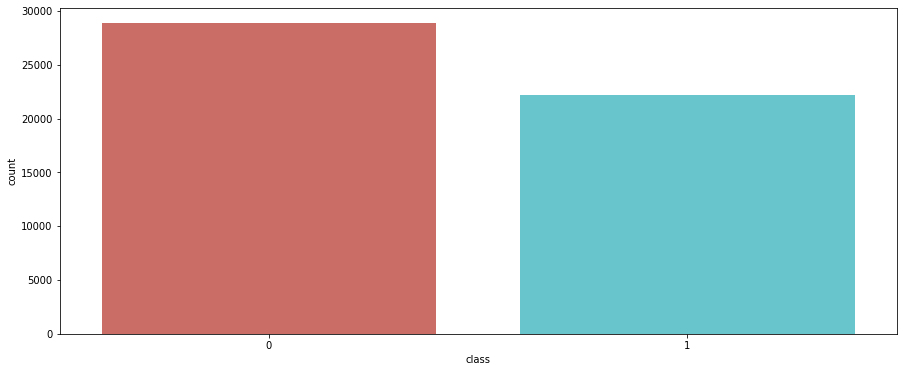

In [16]:
plt.figure(figsize=(15,6))
sns.countplot('class', data=data, palette='hls')
plt.show()

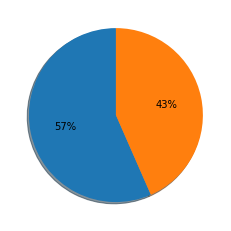

In [19]:
plt.pie(
    data['class'].value_counts(),
    autopct = '%0.0f%%', 
    shadow = 'True',
    startangle = 90
)
plt.show()

In [29]:
data_trns = data.copy()
data_trns['total_char_len'] = data_trns['lyric'].str.len()
data_trns['total_word_count'] = data_trns['lyric'].str.split().str.len()

In [34]:
total_char_len = data_trns['total_char_len'].sum()
print(f"total character length is {total_char_len}")
num_row = data_trns['total_char_len'].shape[0]
print(f"total number of rows is {num_row}")
avg_char_len = data_trns['total_char_len'].mean()
print(f"average character length is {avg_char_len}")

total character length is 2032812
total number of rows is 51054
average character length is 39.81689975320249


In [35]:
total_words = data_trns['total_word_count'].sum()
print(f"total word count is {total_words}")
num_row = data_trns['total_word_count'].shape[0]
print(f"total number of rows is {num_row}")
avg_words = data_trns['total_word_count'].mean()
print(f"average number of words is {avg_words}")

total word count is 418280
total number of rows is 51054
average number of words is 8.19289379872292


In [22]:
import string
import re
import nltk
from nltk.util import pr
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from nltk.corpus import stopwords

In [24]:
stemmer = nltk.SnowballStemmer('english')
nltk.download('stopwords')
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erinkim/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword] 
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [39]:
data_trns['lyric'] = data_trns['lyric'].apply(clean)

In [41]:
data_trns['total_char_len'] = data_trns['lyric'].str.len()
data_trns['total_word_count'] = data_trns['lyric'].str.split().str.len()

In [42]:
total_char_len = data_trns['total_char_len'].sum()
print(f"total character length is {total_char_len}")
num_row = data_trns['total_char_len'].shape[0]
print(f"total number of rows is {num_row}")
avg_char_len = data_trns['total_char_len'].mean()
print(f"average character length is {avg_char_len}")

total character length is 1141207
total number of rows is 51054
average character length is 22.35294002428801


In [43]:
total_words = data_trns['total_word_count'].sum()
print(f"total word count is {total_words}")
num_row = data_trns['total_word_count'].shape[0]
print(f"total number of rows is {num_row}")
avg_words = data_trns['total_word_count'].mean()
print(f"average number of words is {avg_words}")

total word count is 227389
total number of rows is 51054
average number of words is 4.453891957535159


In [45]:
x = np.array(data_trns['lyric'])
y = np.array(data_trns['class'])

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(x) 
vectorizer.get_feature_names_out()
print(X.shape)

(51054, 11066)


In [50]:
first_vector = X[0]
df = pd.DataFrame(
    first_vector.T.todense(),
    index = vectorizer.get_feature_names(),
    columns = ["tfidf"]) 

df.sort_values(by = ["tfidf"],ascending=False)

,tfidf
thinkin,0.549645
drink,0.539251
without,0.520521
cant,0.368994
aa,0.000000
...,...
franchi,0.000000
franci,0.000000
franck,0.000000
frank,0.000000


In [52]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i)
    km.fit_predict(X)
    wcss.append(km.inertia_)

In [55]:
wcss

[50493.07797044366,
 50048.64249377392,
 49694.40586999069,
 49418.76839979505,
 49245.45446884958,
 49124.10868618675,
 48619.86115584997,
 48553.89295175163,
 48499.939202183974,
 48240.10973277212]

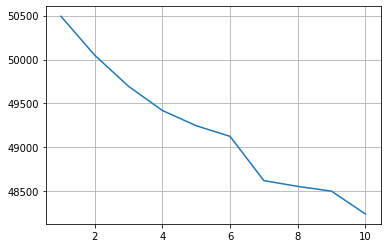

In [57]:
plt.plot(range(1,11), wcss)
plt.grid()
plt.show()

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.3,
        random_state = 39
)

In [60]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [61]:
print("Training Accuracy :", clf.score(X_train, y_train)) 
print("Testing Accuracy :", clf.score(X_test, y_test))

Training Accuracy : 0.9912415703612503
Testing Accuracy : 0.8013971404321996


In [75]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [76]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      8723
           1       0.75      0.80      0.78      6594

    accuracy                           0.80     15317
   macro avg       0.80      0.80      0.80     15317
weighted avg       0.80      0.80      0.80     15317



In [77]:
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[6978 1745]
 [1297 5297]]


In [78]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(n_estimators=2) 
GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

In [79]:
print("Training Accuracy :", GB.score(X_train, y_train)) 
print("Testing Accuracy :", GB.score(X_test, y_test))

Training Accuracy : 0.564177183311414
Testing Accuracy : 0.5694979434615134


In [80]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73      8723
           1       0.00      0.00      0.00      6594

    accuracy                           0.57     15317
   macro avg       0.28      0.50      0.36     15317
weighted avg       0.32      0.57      0.41     15317



In [81]:
matrix = confusion_matrix(y_test,y_pred) 
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[8723    0]
 [6594    0]]


In [83]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier= RandomForestClassifier(
    n_estimators= 10, 
    criterion="entropy"
)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [84]:
print("Training Accuracy :", rf_classifier.score(X_train, y_train)) 
print("Testing Accuracy :", rf_classifier.score(X_test, y_test))

Training Accuracy : 0.9804684220835549
Testing Accuracy : 0.8282300711627604


In [85]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8723
           1       0.82      0.77      0.79      6594

    accuracy                           0.83     15317
   macro avg       0.83      0.82      0.82     15317
weighted avg       0.83      0.83      0.83     15317



In [86]:
matrix = confusion_matrix(y_test,y_pred) 
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[7602 1121]
 [1510 5084]]


In [87]:
from sklearn.svm import LinearSVC

LSVCClf = LinearSVC(
    dual = False, 
    random_state = 42, 
    penalty = 'l1',
    tol = 1e-5
)
LSVCClf.fit(X_train, y_train)

y_pred = LSVCClf.predict(X_test)

In [88]:
print("Training Accuracy :", LSVCClf.score(X_train, y_train)) 
print("Testing Accuracy :", LSVCClf.score(X_test, y_test))

Training Accuracy : 0.8386546156644374
Testing Accuracy : 0.7728667493634523


In [89]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      8723
           1       0.72      0.78      0.75      6594

    accuracy                           0.77     15317
   macro avg       0.77      0.77      0.77     15317
weighted avg       0.78      0.77      0.77     15317



In [90]:
matrix = confusion_matrix(y_test,y_pred) 
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[6723 2000]
 [1479 5115]]


In [91]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression() 
logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)

In [92]:
print("Training Accuracy :", logreg_model.score(X_train, y_train)) 
print("Testing Accuracy :", logreg_model.score(X_test, y_test))

Training Accuracy : 0.804460363208999
Testing Accuracy : 0.7695371156231638


In [93]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      8723
           1       0.75      0.70      0.72      6594

    accuracy                           0.77     15317
   macro avg       0.77      0.76      0.76     15317
weighted avg       0.77      0.77      0.77     15317



In [94]:
matrix = confusion_matrix(y_test,y_pred) 
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[7146 1577]
 [1953 4641]]
